In [129]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [130]:
import sys
import math
import string
import operator
import random
import collections
import datetime
import itertools
import functools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import IPython
import sympy as sp
import sympy.plotting as splt
import sympy.physics.vector as spv
import sympy.physics.mechanics as spm
import scipy.constants as spc

import IPython.display as ipd
spv.init_vprinting()
%matplotlib inline


In [131]:
print(f"""
    Python version {sys.version}
    IPython version {IPython.__version__}
    Numpy version {np.__version__}
    mathplotlib version {matplotlib.__version__}
    Pandas version {pd.__version__}
    Seaborn version {sns.__version__}
    """
      )



    Python version 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
    IPython version 8.4.0
    Numpy version 1.23.3
    mathplotlib version 3.5.2
    Pandas version 1.4.4
    Seaborn version 0.12.0
    


In [132]:
def directory(obj):
    return [
        str for str in dir(obj)
        if callable(getattr(obj, str)) & ~str.startswith('_')
    ]


In [133]:
print(IPython.utils.text.columnize(directory(ipd)))


Audio          JSON               Video               display_markdown      
Code           Javascript         VimeoVideo          display_pdf           
DisplayHandle  Latex              YouTubeVideo        display_png           
DisplayObject  Markdown           clear_output        display_pretty        
FileLink       Math               display             display_svg           
FileLinks      Pretty             display_html        publish_display_data  
GeoJSON        ProgressBar        display_javascript  set_matplotlib_close  
HTML           SVG                display_jpeg        set_matplotlib_formats
IFrame         ScribdDocument     display_json        update_display        
Image          TextDisplayObject  display_latex     



In [134]:
print(IPython.utils.text.columnize(dir(sp.S)))


Catalan           Naturals            __dir__            __ne__             
ComplexInfinity   Naturals0           __doc__            __new__            
Complexes         NegativeInfinity    __eq__             __reduce__         
EmptySequence     NegativeOne         __format__         __reduce_ex__      
EmptySet          One                 __ge__             __repr__           
EulerGamma        Pi                  __getattr__        __setattr__        
Exp1              Rationals           __getattribute__   __sizeof__         
GoldenRatio       Reals               __gt__             __slots__          
Half              TribonacciConstant  __hash__           __str__            
IdentityFunction  UniversalSet        __init__           __subclasshook__   
ImaginaryUnit     Zero                __init_subclass__  _classes_to_install
Infinity          __call__            __le__             false              
Integers          __class__           __lt__             register           

In [135]:
HALF = sp.S.Half
PI = sp.pi
E = sp.exp
POSITIVEINFINITY = sp.S.Infinity


# Support Functions

In [136]:
def reference_frame(
    frame: str,
    x=r'\imath', y=r'\jmath', z=r'\mathbf k'
) -> spv.ReferenceFrame:
    return spv.ReferenceFrame(
        frame, latexs=(
            fr'\; {{}}^\mathcal {frame} \hat {x}',
            fr'\;{{}}^\mathcal {frame} \hat {y}',
            fr'\: {{}}^\mathcal {frame} \hat {{z}}'
        )
    )


def vector(F: spv.ReferenceFrame, rx, ry, rz=0) -> spv.Vector:
    return rx*F.x + ry*F.y + rz*F.z


def vector_cos(
    F: spv.ReferenceFrame, magnitude,
    anglex, angley, anglez=sp.pi/2
) -> spv.Vector:
    return (magnitude *
            (sp.cos(anglex)*F.x
             + sp.cos(angley)*F.y
             + sp.cos(anglez)*F.z
             )
            )


def vector_line(
    start: spv.Vector, finish: spv.Vector
) -> spv.Vector:
    return finish - start


def vector_line_eqn(
    F: spv.ReferenceFrame, start: spv.Vector, finish: spv.Vector, kappa
) -> spv.Vector:
    return start + vector_line(start, finish).normalize()*kappa


def angle_between_vectors(a: spv.Vector, b: spv.Vector):
    return sp.acos(a.dot(b)/a.magnitude()/b.magnitude())


def make2Dsymbols(symbol_list):
    return [
        sp.symbols(f"{ch}_x:y", real=True)
        for ch in symbol_list
    ]


F, E = make2Dsymbols(['F', 'E'])
assert str(F) == '(F_x, F_y)'
assert str(E) == '(E_x, E_y)'


__Solutions to equilibrium equations__

In [137]:
def solve_equilibrium_equation(
    frame: spv.ReferenceFrame,
    unknown_variables: list[sp.Symbol],
    forces: list[spv.Vector],
    moments: list[spv.Vector]
):
    """Solve a set of vectors for unknowns

    Args:
        frame (spv.ReferenceFrame): Reference frame containing vectors
        unknown_variables (list[sp.Symbol]): List of unknwn variabes in 
        the vectors which are to be solved for.

        forces (list[spv.Vector]): List of force vectors that are in 
        equilibrium

        moments (list[spv.Vector]): List of moment vectors that are in 
        equilibrium

    Returns:
        _type_: _description_
    """
    total_force = sum(forces)
    total_moments = sum(moments)
    # display(total_force)
    # display(total_moments)
    eqn = sp.Eq(
        sp.Matrix.vstack(
            total_force.to_matrix(frame),
            total_moments.to_matrix(frame)),
        sp.zeros(6, 1)
    )
    # display(eqn)
    return sp.solve(eqn, unknown_variables, dict=True)


[Distributed load calculation][]

[Distributed load calculation]: https://engineeringstatics.org/distributed-loads.html

In [138]:
def distributed_load(
    load_distribution_expr: sp.core.expr.Expr,
    integration_variable: sp.core.expr.Expr,
    upper: sp.core.expr.Expr
) -> sp.core.expr.Expr:

    equivalent_force = sp.integrate(
        load_distribution_expr,
        [integration_variable, 0, upper]
    )

    moment = sp.integrate(
        integration_variable*load_distribution_expr,
        [integration_variable, 0, upper]
    )

    position_of_equivalent_force = sp.symbols(r"\overline{x}")
    eqn = sp.Eq(equivalent_force*position_of_equivalent_force, moment)
    point_of_application = sp.solve(eqn, position_of_equivalent_force)
    return equivalent_force, point_of_application[0]


x = sp.symbols("x")
assert distributed_load(sp.Rational(10, 6)*x, x, 6) == (30, 4)
assert distributed_load(4, x, 4) == (16, 2)


# Sympy 
1. [SymPy Documentation][]
1. [SymPy Modules Reference][]
1. [Sympy Live][]
1. [Scipy Lecture Notes][]
1. [Sympy Tutorial Main Site][]
1. [Sympy Tutorial - Russia][]
1. [Sympy examples 1][]
1. [SymPy: symbolic computing in Python](https://peerj.com/articles/cs-103/) looks cool
1. Good [sympy tutorial](http://www.cfm.brown.edu/people/dobrush/am33/SymPy/index.html) and [plotting](http://www.cfm.brown.edu/people/dobrush/am33/SymPy/part1.html) by Vladimir Dobrushkin


[SymPy Documentation]: http://docs.sympy.org/latest/index.html#welcome-to-sympy-s-documentation

[SymPy Modules Reference]: http://docs.sympy.org/latest/modules/index.html#sympy-modules-reference

[Sympy Live]: http://live.sympy.org/

[Scipy Lecture Notes]: http://www.scipy-lectures.org/

[Sympy Tutorial Main Site]: http://docs.sympy.org/latest/tutorial/index.html#sympy-tutorial

[Sympy Tutorial - Russia]: http://www.inp.nsk.su/~grozin/python/sympy.html

[Sympy examples 1]: https://github.com/sbu-python-class/python-science/blob/master/lectures/06-sympy/sympy-examples.ipynb



# Symbols
1. [symbols][]
1. [assumptions][]

[symbols]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.symbol.symbols
[assumptions]:http://docs.sympy.org/latest/modules/core.html?highlight=match#module-sympy.core.assumptions

In [139]:
x, h = sp.symbols('x, h')
n, k = sp.symbols('n, k', positive=True, integer=True)
x, h, n, k


In [140]:
a4, a5 = sp.symbols('a4:6')
a4, a5


In [141]:
c = sp.symbols("c_{{1:4}{1:4}}")
sp.Matrix(3,3, c)

⎡c_{{1}{1}}  c_{{1}{2}}  c_{{1}{3}}⎤
⎢                                  ⎥
⎢c_{{2}{1}}  c_{{2}{2}}  c_{{2}{3}}⎥
⎢                                  ⎥
⎣c_{{3}{1}}  c_{{3}{2}}  c_{{3}{3}}⎦

In [142]:
(
    sp.S.One,
    sp.S.Half,
    sp.S.NegativeOne,
    sp.S.NegativeInfinity,
    sp.oo,
    sp.S.Infinity,
    sp.pi,
    sp.E,
    sp.S.Exp1,
    sp.S.GoldenRatio,
    sp.GoldenRatio,
    sp.S.EulerGamma,
    sp.EulerGamma,
    sp.I
)


In [143]:
(
    sp.S.One,
    sp.S.Half,
    sp.S.NegativeOne,
    sp.S.NegativeInfinity,
    sp.oo,
    sp.S.Infinity,
    sp.pi,
    sp.E,
    sp.S.Exp1,
    sp.S.GoldenRatio,
    sp.GoldenRatio,
    sp.S.EulerGamma,
    sp.EulerGamma,
    sp.I
)


# Lambdify

In [144]:
x, y = sp.symbols('x, y', real=True)
expr = sp.asin(x**2/y) +PI
expr

In [145]:
expr_f =  sp.lambdify([x, y], expr)
expr_f(1, 2)

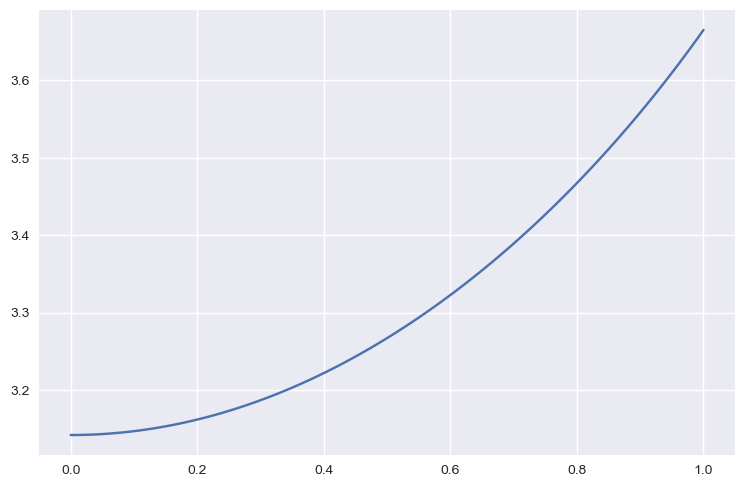

In [146]:
x_num =  np.linspace(0, 1, 100)
y_num = 2
plt.plot(x_num, expr_f(x_num, y_num))

# Printing

In [147]:
G, M, d = sp.symbols('G, M, d', real=True, positive=True)
N = spm.ReferenceFrame('N', latexs=(
    r'\hat{\imath}', r'\hat{\jmath}', r'\hat{k}'))


In [148]:
r12 = 4*d*N.x
r13 = 6*d*N.x
ipd.display(r12), ipd.display(r13)


(None, None)

In [149]:
f21 = -G*5*M*2*M/r12.magnitude()**2*r12.normalize()
f23 = G*2*M*M/(r13 - r12).magnitude()**2*(r13 - r12).normalize()

ipd.display(
    ipd.Latex(rf'$r_{{21}}={sp.latex(f21)}$'),
    ipd.Latex(rf'$r_{{23}}={sp.latex(f23)}$'),
    ipd.Latex(rf'$r_{{21}} + r_{{23}} ={sp.latex(f23+f21)}$')
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [150]:
ipd.display(
    ipd.Latex(
        rf'$r_{{21}}={sp.latex(f21)} \quad ' 
        rf'r_{{21}}={sp.latex(f21)}$'
    )
)

<IPython.core.display.Latex object>

In [151]:
ipd.display(
    ipd.Math(
        rf'$ {spv.vlatex(f21)}\quad '
        rf'  {spv.vlatex(f23)}\quad $'
    )
)

<IPython.core.display.Math object>

In [152]:
ipd.display(
    ipd.Math(
        rf'$ {spv.vlatex(f21)} \quad '
        rf'  {spv.vlatex(f23)} \quad $'
    )
)

<IPython.core.display.Math object>

In [153]:
ipd.display(
    ipd.Math(
        rf'$ {spv.vlatex(x**2)}\quad '
        rf'  {spv.vlatex(x**3)}\quad $'
    )
)

<IPython.core.display.Math object>

In [214]:
F = reference_frame("F")
x = spv.dynamicsymbols('x')
vec_r = x*F.x

ipd.display(
    ipd.Math(
        rf'$ {spv.vlatex(vec_r)}\quad '
        rf'  {spv.vlatex(vec_r.dt(F))}\quad '
        rf'  {spv.vlatex(vec_r.dt(F).dt(F))}\quad $'
    )
)

<IPython.core.display.Math object>

# Function
* [Function][]
* [Expand][]
* [Subs][]
* [Assumptions][]
* [Elementary Functions, Piecewise](https://docs.sympy.org/latest/modules/functions/elementary.html)



[Function]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.Function

[Subs]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.Subs

[Expand]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.expand

[Assumptions]: http://docs.sympy.org/latest/modules/core.html#module-sympy.core.assumptions

In [154]:
assumptions = [
    'real',
    'extended_real',
    'complex',
    'imaginary',
    'integer',
    'irrational',
    'rational',
    'negative',
    'positive'
]
assumptions


['real',
 'extended_real',
 'complex',
 'imaginary',
 'integer',
 'irrational',
 'rational',
 'negative',
 'positive']

In [155]:
hints_expand = [
    'mul',
    'modulus',
    'power_base',
    'power_exp',
    'mul',
    'log',
    'multinomial',
    'basic',
    'complex',
    'func',
    'trig'
]
hints_expand


['mul',
 'modulus',
 'power_base',
 'power_exp',
 'mul',
 'log',
 'multinomial',
 'basic',
 'complex',
 'func',
 'trig']

In [156]:
(
    sp.nsimplify(6.28, [sp.pi], tolerance=0.01),
    sp.nsimplify(0.33333, tolerance=0.001),
    sp.nsimplify(sp.cos(sp.atan(1./3)))
)


## Function List
* [simplify][], inverse operation of expand
* [apart][], partial fraction decomposition
* [together][], merge to one common division
* [collect][], collect terms with same power
* [collect sqrt][], collect terms with same power
* [radsimp][], rationalize the denominator
* trigsimp, use trig. identities to simplify
* powsimp, combine bases and exponents
* [factor][], Compute the factorization of expression, f, into irreducibles.
* [cancel][] ,Cancel common factors in a rational function f/g.
* [Split into numerator, demoninator](http://docs.sympy.org/latest/modules/core.html?highlight=as_numer_denom#sympy.core.expr.Expr.as_numer_denom)

[simplify]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.simplify.simplify

[apart]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20together#sympy.polys.partfrac.apart

[together]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20together#sympy.polys.rationaltools.together

[collect]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.radsimp.collect
[collect sqrt]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#collect-sqrt

[radsimp]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.radsimp.radsimp

[factor]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20factor#sympy.polys.polytools.factor

[cancel]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20cancel#sympy.polys.polytools.Poly.cancel


if ratio=1, simplify output can’t be longer than input
If ratio=oo, simplify will be applied anyway:

In [157]:
sp.simplify(sp.cos(x)**2 + sp.sin(x)**2)


In [158]:
funcs_expand = [
    sp.expand_log,
    sp.expand_mul,
    sp.expand_multinomial,
    sp.expand_complex,
    sp.expand_trig,
    sp.expand_power_base,
    sp.expand_power_exp,
    sp.expand_func,
    sp.hyperexpand
]
funcs_expand


[<function sympy.core.function.expand_log(expr, deep=True, force=False, factor=False)>,
 <function sympy.core.function.expand_mul(expr, deep=True)>,
 <function sympy.core.function.expand_multinomial(expr, deep=True)>,
 <function sympy.core.function.expand_complex(expr, deep=True)>,
 <function sympy.core.function.expand_trig(expr, deep=True)>,
 <function sympy.core.function.expand_power_base(expr, deep=True, force=False)>,
 <function sympy.core.function.expand_power_exp(expr, deep=True)>,
 <function sympy.core.function.expand_func(expr, deep=True)>,
 <function sympy.simplify.hyperexpand.hyperexpand(f, allow_hyper=False, rewrite='default', place=None)>]

In [159]:
sp.diff(sp.tan(x), x)

## Limit

In [160]:
x = sp.symbols('x')

In [161]:
sp.limit((sp.tan(x+h) - sp.tan(x))/h, h, 0)

In [162]:
sp.limit(sp.sin(x/2 + sp.sin(x)), x, PI)

## Derivatives

In [163]:
x = sp.symbols('x')

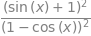

In [164]:
expr = ((1 + sp.sin(x))/(1 - sp.cos(x)))**2
expr

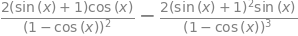

In [165]:
expr.diff()

In [166]:
f,g =  sp.symbols('f, g', cls = sp.Function)
f(x), g(x)

In [167]:
f(x + g(x))

In [168]:
sp.diff(f(x + g(x)), x)

⎛d           ⎞ ⎛ d        ⎞│           
⎜──(g(x)) + 1⎟⋅⎜───(f(ξ₁))⎟│           
⎝dx          ⎠ ⎝dξ₁       ⎠│ξ₁=x + g(x)

In [169]:
sp.diff(f(x + g(x)), x).subs(g(x), sp.sin(x))

⎛d             ⎞ ⎛ d        ⎞│             
⎜──(sin(x)) + 1⎟⋅⎜───(f(ξ₁))⎟│             
⎝dx            ⎠ ⎝dξ₁       ⎠│ξ₁=x + sin(x)

## Anti Derivatives

In [170]:
x= sp.symbols('x')

In [171]:
sp.integrate(sp.csc(x)*sp.cot(x))

In [172]:
sp.integrate(
    sp.exp(x) / sp.sqrt(sp.exp(2*x) + 9), 
    (x, 0, sp.log(4))
)

In [173]:
t = sp.symbols('t')

In [174]:
sp.integrate(x**10*sp.exp(x), (x, 1, t))

In [175]:
sp.integrate(sp.log(x), x)


In [176]:
sp.integrate(
    sp.exp(-x**2),
    (x, sp.S.NegativeInfinity, sp.S.Infinity)
)


In [177]:
sp.cos(x).series(x, 0, 10), sp.cos(x).series(x, 0, 10).removeO()


# Multivariable Calculus

In [178]:
x, y, z, u1, u2, u3, v1, v2, v3, t = sp.symbols('x:z, u_1:4, v_1:4, t')
x, y, z, u1, u2, u3, t

## Vectors and Geometry

In [179]:
u, v = sp.Matrix([u1, u2, u3]), sp.Matrix([v1, v2, v3])
u, v

⎛⎡u₁⎤  ⎡v₁⎤⎞
⎜⎢  ⎥  ⎢  ⎥⎟
⎜⎢u₂⎥, ⎢v₂⎥⎟
⎜⎢  ⎥  ⎢  ⎥⎟
⎝⎣u₃⎦  ⎣v₃⎦⎠

In [180]:
display(2*u + v)
display(u.dot(v))
display(u.cross(v))
display(u.norm())

⎡2⋅u₁ + v₁⎤
⎢         ⎥
⎢2⋅u₂ + v₂⎥
⎢         ⎥
⎣2⋅u₃ + v₃⎦

⎡u₂⋅v₃ - u₃⋅v₂ ⎤
⎢              ⎥
⎢-u₁⋅v₃ + u₃⋅v₁⎥
⎢              ⎥
⎣u₁⋅v₂ - u₂⋅v₁ ⎦

In [181]:
proj_u_on_v = u.dot(v)/v.norm()**2 * v
proj_u_on_v

⎡v₁⋅(u₁⋅v₁ + u₂⋅v₂ + u₃⋅v₃)⎤
⎢──────────────────────────⎥
⎢      2       2       2   ⎥
⎢  │v₁│  + │v₂│  + │v₃│    ⎥
⎢                          ⎥
⎢v₂⋅(u₁⋅v₁ + u₂⋅v₂ + u₃⋅v₃)⎥
⎢──────────────────────────⎥
⎢      2       2       2   ⎥
⎢  │v₁│  + │v₂│  + │v₃│    ⎥
⎢                          ⎥
⎢v₃⋅(u₁⋅v₁ + u₂⋅v₂ + u₃⋅v₃)⎥
⎢──────────────────────────⎥
⎢      2       2       2   ⎥
⎣  │v₁│  + │v₂│  + │v₃│    ⎦

## Vector Calculus

### Differentiation

In [182]:
r = sp.Matrix([3*t, sp.sin(t), t**2])
r

⎡ 3⋅t  ⎤
⎢      ⎥
⎢sin(t)⎥
⎢      ⎥
⎢   2  ⎥
⎣  t   ⎦

In [183]:
r.diff(t)

⎡  3   ⎤
⎢      ⎥
⎢cos(t)⎥
⎢      ⎥
⎣ 2⋅t  ⎦

### Integration

In [184]:
r = sp.Matrix([sp.exp(t)*sp.cos(t), t**4, 1/(1+t**2)])
r

⎡ t       ⎤
⎢ℯ ⋅cos(t)⎥
⎢         ⎥
⎢    4    ⎥
⎢   t     ⎥
⎢         ⎥
⎢   1     ⎥
⎢ ──────  ⎥
⎢  2      ⎥
⎣ t  + 1  ⎦

In [185]:
r.integrate(t)

⎡ t           t       ⎤
⎢ℯ ⋅sin(t)   ℯ ⋅cos(t)⎥
⎢───────── + ─────────⎥
⎢    2           2    ⎥
⎢                     ⎥
⎢          5          ⎥
⎢         t           ⎥
⎢         ──          ⎥
⎢         5           ⎥
⎢                     ⎥
⎣       atan(t)       ⎦

# Pattern Matching
* [match][] in [Basic][]
* [Wild][]
* [WildFunction][]

[Basic]: http://docs.sympy.org/latest/modules/core.html?highlight=match#id15

[Wild]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.symbol.Wild

[WildFunction]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.WildFunction

[match]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.basic.Basic.match 

In [186]:
p = sp.Wild('p', exclude=[x])
q = sp.Wild('q', exclude=[x])
(5*x**2 + 3*x).match(p*x**2 + q*x), (x**2).match(p*x**q)


In [187]:
f = sp.WildFunction('f', nargs=1)
(5*sp.cos(x)).match(p*f), (sp.cos(3*x)).match(f)


# Replacement

* [replace][1] replace an expression. An example is found in [Young and Freedman][2] solutions in sympy

[1]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.basic.Basic.replace
[2]:../physics/YoungAndFreedman13/Chapter05-Applying-Newtons-Laws/Chapter05P110-Rotating-System.ipynb

# Calculus
* [Calculus][2]
* [Integrals][1]
* [Solving differential equations][3]
* [classify ODE][4]

[4]: http://docs.sympy.org/latest/modules/solvers/ode.html?highlight=dsolve#classify-ode
[3]: http://docs.sympy.org/latest/tutorial/solvers.html#solving-differential-equations
[2]: http://docs.sympy.org/latest/tutorial/calculus.html?highlight=dsolve#calculus
[1]: http://docs.sympy.org/latest/modules/integrals/integrals.html?highlight=sympy.integrals#module-sympy.integrals

# Series and Summations

Some examples of series and summations may be found in mathematical problems for physics.
  * [Summation][1]
  * [Series][2]

[1]: ../../Physics/Physics-Problems-To-Solve/physics-mechanics/physics-mechanics-SMR-P001-binomial-expansion-Summation.ipynb
[2]: ../../Physics/Physics-Problems-To-Solve/physics-mechanics/physics-mechanics-SMR-P001-binomial-expansion-Series.ipynb

# Matrices
1 [Matrices][]

[Matrices]: http://docs.sympy.org/latest/modules/matrices/matrices.html#module-sympy.matrices.matrices

## Selection

In [188]:
A = sp.Matrix(3, 3, sp.symbols('a:i', real=True))
A

⎡a  b  c⎤
⎢       ⎥
⎢d  e  f⎥
⎢       ⎥
⎣g  h  i⎦

In [189]:
A[0,:], A[1,:]

([a  b  c], [d  e  f])

In [190]:
n = 3
a = sp.symbols(f'a_1:{n+1}(1:{n+1})', real=True)
b = sp.symbols(f'b_1:{n+1}(1:{n+1})', real=True)
A, B = sp.Matrix(n, n, a), sp.Matrix(n, n, b)
A, B

⎛⎡a₁₁  a₁₂  a₁₃⎤  ⎡b₁₁  b₁₂  b₁₃⎤⎞
⎜⎢             ⎥  ⎢             ⎥⎟
⎜⎢a₂₁  a₂₂  a₂₃⎥, ⎢b₂₁  b₂₂  b₂₃⎥⎟
⎜⎢             ⎥  ⎢             ⎥⎟
⎝⎣a₃₁  a₃₂  a₃₃⎦  ⎣b₃₁  b₃₂  b₃₃⎦⎠

In [191]:
sp.eye(3), sp.zeros(1, 3), sp.ones(2)


⎛⎡1  0  0⎤                   ⎞
⎜⎢       ⎥             ⎡1  1⎤⎟
⎜⎢0  1  0⎥, [0  0  0], ⎢    ⎥⎟
⎜⎢       ⎥             ⎣1  1⎦⎟
⎝⎣0  0  1⎦                   ⎠

In [192]:
M = sp.eye(3)
M.row_del(0)
M


⎡0  1  0⎤
⎢       ⎥
⎣0  0  1⎦

In [193]:
M1 = sp.eye(n, n)
M1[1, 0] = 2
M1, A, M1*A

⎛⎡1  0  0⎤  ⎡a₁₁  a₁₂  a₁₃⎤  ⎡    a₁₁          a₁₂          a₁₃    ⎤⎞
⎜⎢       ⎥  ⎢             ⎥  ⎢                                     ⎥⎟
⎜⎢2  1  0⎥, ⎢a₂₁  a₂₂  a₂₃⎥, ⎢2⋅a₁₁ + a₂₁  2⋅a₁₂ + a₂₂  2⋅a₁₃ + a₂₃⎥⎟
⎜⎢       ⎥  ⎢             ⎥  ⎢                                     ⎥⎟
⎝⎣0  0  1⎦  ⎣a₃₁  a₃₂  a₃₃⎦  ⎣    a₃₁          a₃₂          a₃₃    ⎦⎠

In [194]:
M, N = sp.zeros(1, 4), sp.zeros(1, 5)
M.row_join(N), M


([0  0  0  0  0  0  0  0  0], [0  0  0  0])

In [195]:
M.cols


## Reshape

In [196]:
A = sp.Matrix(2, 2, [-1, 2, 4, -8])
A


⎡-1  2 ⎤
⎢      ⎥
⎣4   -8⎦

In [197]:
b = sp.symbols('b_0:4', real=True)
B = sp.Matrix(2, 2, b)
B

⎡b₀  b₁⎤
⎢      ⎥
⎣b₂  b₃⎦

## Diagonal

In [198]:
a = sp.symbols('a_0:2', real=True)
b = sp.symbols('b_0:2', real=True)
A, B = sp.diag(*a), sp.diag(*b)
A, B, A*B


⎛⎡a₀  0 ⎤  ⎡b₀  0 ⎤  ⎡a₀⋅b₀    0  ⎤⎞
⎜⎢      ⎥, ⎢      ⎥, ⎢            ⎥⎟
⎝⎣0   a₁⎦  ⎣0   b₁⎦  ⎣  0    a₁⋅b₁⎦⎠

## Transpose

In [199]:
rng = np.random.default_rng(12345)
A = sp.Matrix(rng.integers(low=0, high=10, size=(5,4)))
A, A.T

⎛⎡6  2  7  3⎤                 ⎞
⎜⎢          ⎥  ⎡6  2  9  5  2⎤⎟
⎜⎢2  7  6  6⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎢2  7  3  5  6⎥⎟
⎜⎢9  3  8  3⎥, ⎢             ⎥⎟
⎜⎢          ⎥  ⎢7  6  8  2  6⎥⎟
⎜⎢5  5  2  1⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎣3  6  3  1  9⎦⎟
⎝⎣2  6  6  9⎦                 ⎠

## Reduced Row Echelon Form

In [200]:
A = sp.Matrix(3, 4, [
    1, 2, 3, 4,
    4, 5, 6, 7,
    6, 7, 8, 9
])
A, A.rref()

⎛⎡1  2  3  4⎤  ⎛⎡1  0  -1  -2⎤        ⎞⎞
⎜⎢          ⎥  ⎜⎢            ⎥        ⎟⎟
⎜⎢4  5  6  7⎥, ⎜⎢0  1  2   3 ⎥, (0, 1)⎟⎟
⎜⎢          ⎥  ⎜⎢            ⎥        ⎟⎟
⎝⎣6  7  8  9⎦  ⎝⎣0  0  0   0 ⎦        ⎠⎠

## LU Decomposition

In [201]:
A = sp.Matrix(3, 3, [-3, 2, -1, 6, -6, 7, 3, -4, 4])
R = A.LUdecomposition()
A, R, R[0]*R[1]

⎛⎡-3  2   -1⎤  ⎛⎡1   0  0⎤  ⎡-3  2   -1⎤    ⎞  ⎡-3  2   -1⎤⎞
⎜⎢          ⎥  ⎜⎢        ⎥  ⎢          ⎥    ⎟  ⎢          ⎥⎟
⎜⎢6   -6  7 ⎥, ⎜⎢-2  1  0⎥, ⎢0   -2  5 ⎥, []⎟, ⎢6   -6  7 ⎥⎟
⎜⎢          ⎥  ⎜⎢        ⎥  ⎢          ⎥    ⎟  ⎢          ⎥⎟
⎝⎣3   -4  4 ⎦  ⎝⎣-1  1  1⎦  ⎣0   0   -2⎦    ⎠  ⎣3   -4  4 ⎦⎠

## Gram Schmidt

In [202]:
v1, v2 = sp.Matrix(3, 1, [1, 1, 1]), sp.Matrix(3, 1, [0, 1, 1])
v1, v2, sp.matrices.GramSchmidt([v1, v2], orthonormal=True)

⎛          ⎡⎡√3⎤  ⎡-√6 ⎤⎤⎞
⎜          ⎢⎢──⎥  ⎢────⎥⎥⎟
⎜          ⎢⎢3 ⎥  ⎢ 3  ⎥⎥⎟
⎜⎡1⎤  ⎡0⎤  ⎢⎢  ⎥  ⎢    ⎥⎥⎟
⎜⎢ ⎥  ⎢ ⎥  ⎢⎢√3⎥  ⎢ √6 ⎥⎥⎟
⎜⎢1⎥, ⎢1⎥, ⎢⎢──⎥, ⎢ ── ⎥⎥⎟
⎜⎢ ⎥  ⎢ ⎥  ⎢⎢3 ⎥  ⎢ 6  ⎥⎥⎟
⎜⎣1⎦  ⎣1⎦  ⎢⎢  ⎥  ⎢    ⎥⎥⎟
⎜          ⎢⎢√3⎥  ⎢ √6 ⎥⎥⎟
⎜          ⎢⎢──⎥  ⎢ ── ⎥⎥⎟
⎝          ⎣⎣3 ⎦  ⎣ 6  ⎦⎦⎠

# Plotting

In [203]:
print(IPython.utils.text.columnize(plt.style.available))

Solarize_Light2      grayscale             seaborn-paper       
_classic_test_patch  seaborn               seaborn-pastel      
_mpl-gallery         seaborn-bright        seaborn-poster      
_mpl-gallery-nogrid  seaborn-colorblind    seaborn-talk        
bmh                  seaborn-dark          seaborn-ticks       
classic              seaborn-dark-palette  seaborn-white       
dark_background      seaborn-darkgrid      seaborn-whitegrid   
fast                 seaborn-deep          tableau-colorblind10
fivethirtyeight      seaborn-muted       
ggplot               seaborn-notebook    



In [204]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

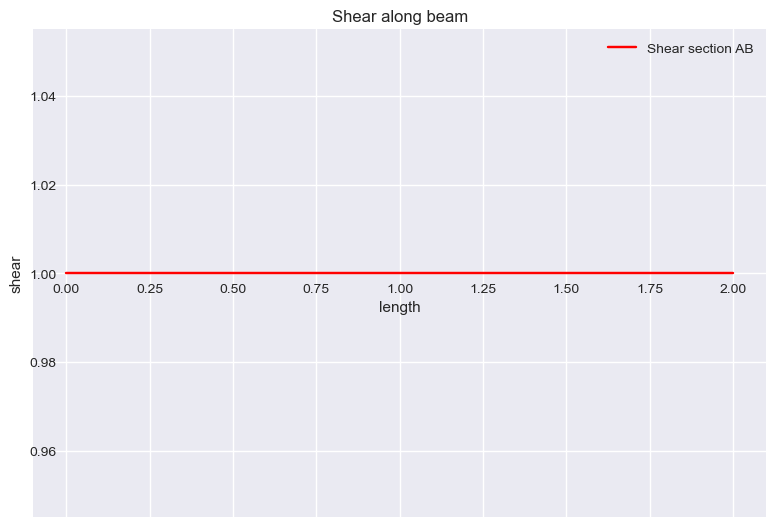

In [205]:
x = sp.symbols("x", real=True)
a = splt.plot(1, (x, 0, 2), show=False)
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB" 
a[0].line_color = 'red'
a.xlabel = 'length'
a.ylabel = 'shear'
a.show()




In [206]:
W0, M0, w0, w1 = 10000, 10000, 4000, 4000
ell = [2, 2, 3, 3, 4]
exprACx = (1000 + 16000*x - 2000*x*x)/3
exprACx

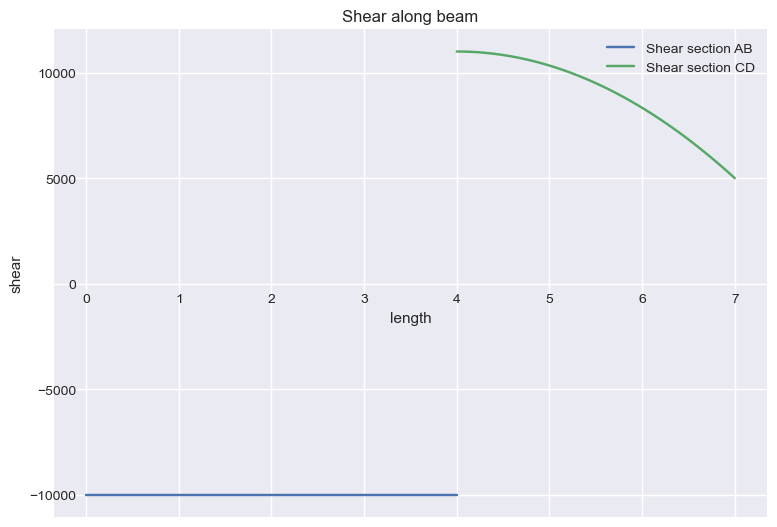

In [207]:
x = sp.symbols("x", real=True)
y = sp.symbols("y", real=True)

a = splt.plot(-W0, (x, 0, sum(ell[:2])), show=False)
b = splt.plot(exprACx, (x, sum(ell[:2]), sum(ell[:3])), show=False)
a.append(b[0])
# a.append(c[0])
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a[1].label = "Shear section CD"
a.xlabel = 'length'
a.ylabel = 'shear'
a.show()



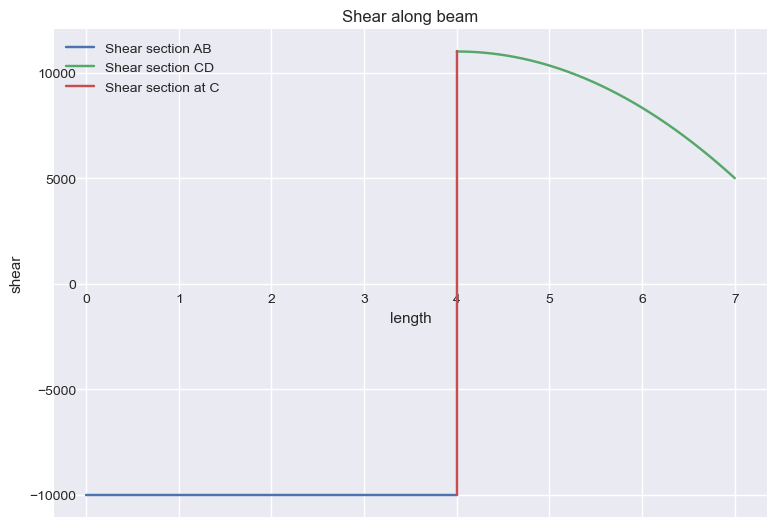

In [208]:
x = sp.symbols("x", real=True)
y = sp.symbols("y", real=True)

a = splt.plot(-W0, (x, 0, sum(ell[:2])), show=False)
b = splt.plot(exprACx, (x, sum(ell[:2]), sum(ell[:3])), show=False)
c = splt.plot_parametric((4, y), (y, -10000, 11000), show=False )
a.append(b[0])
a.append(c[0])
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a[1].label = "Shear section CD"
a[2].label = "Shear section at C"
a.xlabel = 'length'
a.ylabel = 'shear'
a.show()



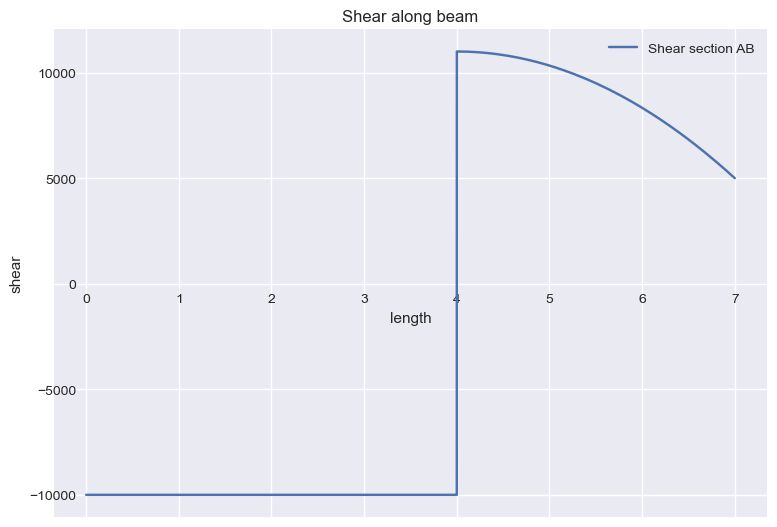

In [209]:
p =sp.Piecewise(
    (-W0, sp.Interval(0, 4).contains(x)),
    (exprACx, sp.Interval(4, 7).contains(x))
)

x = sp.symbols("x", real=True)

a = splt.plot(p, (x, 0, sum(ell[:3])), show=False)
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a.xlabel = 'length'
a.ylabel = 'shear'
a.show()

